# cadCAD Template: Robot and the Marbles - Part 4

![](images/Overview.jpeg)
![](images/Mech1.jpeg)


## Non-determinism
Non-deterministic systems exhibit different behaviors on different runs for the same input. The order of heads and tails in a series of 3 coin tosses, for example, is non deterministic. 

Our robots and marbles system is currently modelled as a deterministic system. Meaning that every time we run the simulation: none of the robots act on timestep 1; robot 1 acts on timestep 2; robot 2 acts on timestep 3; an so on. 

If however we were to define that at every timestep each robot would act with a probability P, then we would have a non-deterministic (probabilistic) system. Let's make the following changes to our system.
* Robot 1: instead of acting once every two timesteps, there's a 50% chance it will act in any given timestep
* Robot 2: instead of acting once every three timesteps, there's a 33.33% chance it will act in any given timestep

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib 
from tabulate import tabulate
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
import config
from cadCAD import configs
import matplotlib.pyplot as plt

%matplotlib inline

exec_mode = ExecutionMode()

In [2]:
# Run Cad^2

first_config = configs # only contains config1
single_proc_ctx = ExecutionContext(context=exec_mode.single_proc)
run = Executor(exec_context=single_proc_ctx, configs=first_config)

raw_result, tensor_field = run.main()
df = pd.DataFrame(raw_result)
df.set_index(['run', 'timestep', 'substep'])

single_proc: [<cadCAD.configuration.Configuration object at 0x7f406d1bee80>]


box_A  box_B
run timestep substep              
1   0        0           10      0
    1        1            9      1
    2        1            8      2
    3        1            8      2
    4        1            6      4
    5        1            5      5
    6        1            5      5
    7        1            5      5
    8        1            5      5
    9        1            5      5
    10       1            5      5

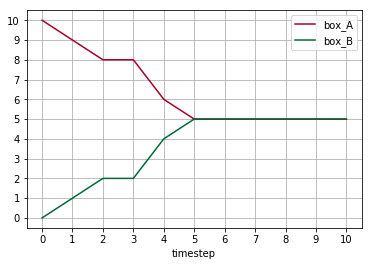

In [3]:
df.plot('timestep', ['box_A', 'box_B'], grid=True, 
        colormap = 'RdYlGn',
        xticks=list(df['timestep'].drop_duplicates()), 
        yticks=list(range(1+(df['box_A']+df['box_B']).max())));

### Since it is random, lets run it again:

single_proc: [<cadCAD.configuration.Configuration object at 0x7f406d1bee80>]


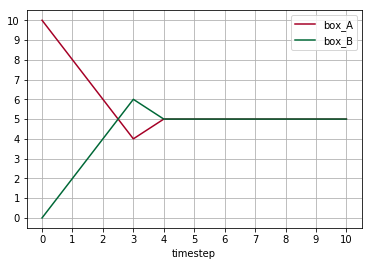

In [4]:
# Run Cad^2

first_config = configs # only contains config1
single_proc_ctx = ExecutionContext(context=exec_mode.single_proc)
run = Executor(exec_context=single_proc_ctx, configs=first_config)

raw_result, tensor_field = run.main()
df = pd.DataFrame(raw_result)
df.plot('timestep', ['box_A', 'box_B'], grid=True, 
        colormap = 'RdYlGn',
        xticks=list(df['timestep'].drop_duplicates()), 
        yticks=list(range(1+(df['box_A']+df['box_B']).max())));

### Run 50 Monte Carlo Runs
In order to take advantage of cadCAD's Monte Carlo simulation features, we should modify the configuration file so as to define the number of times we want the same simulation to be run. This is done in the N key of the sim_config dictionary.

In [5]:
import config2
first_config = configs # only contains config1
single_proc_ctx = ExecutionContext(context=exec_mode.single_proc)
run = Executor(exec_context=single_proc_ctx, configs=first_config)

raw_result, tensor_field = run.main()
df2 = pd.DataFrame(raw_result)

single_proc: [<cadCAD.configuration.Configuration object at 0x7f406d1bee80>, <cadCAD.configuration.Configuration object at 0x7f40504a8588>]


In [6]:
from IPython.display import display
tmp_rows = pd.options.display.max_rows
pd.options.display.max_rows = 10
display(df2.set_index(['run', 'timestep', 'substep']))
pd.options.display.max_rows = tmp_rows

box_A  box_B
run timestep substep              
1   0        0           10      0
    1        1            8      2
    2        1            7      3
    3        1            6      4
    4        1            6      4
...                     ...    ...
50  6        1            7      3
    7        1            7      3
    8        1            5      5
    9        1            5      5
    10       1            5      5

[550 rows x 2 columns]

Plotting two of those runs allows us to see the different behaviors over time.

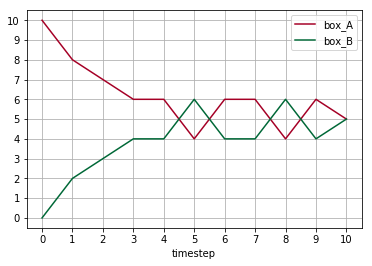

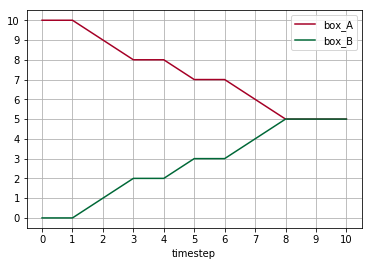

In [7]:
df2[df2['run']==1].plot('timestep', ['box_A', 'box_B'], grid=True,
                          xticks=list(df['timestep'].drop_duplicates()), 
                          yticks=list(range(11)),
                          colormap = 'RdYlGn');
df2[df2['run']==9].plot('timestep', ['box_A', 'box_B'], grid=True,
                            xticks=list(df['timestep'].drop_duplicates()), 
                            yticks=list(range(11)),
                            colormap = 'RdYlGn');

If we plot all those runs onto a single chart, we can see every possible trajectory for the number of marbles in each box.

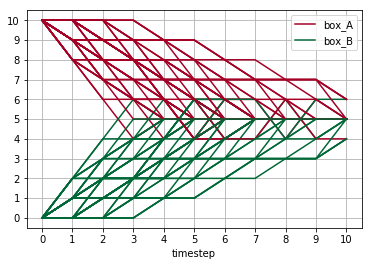

In [8]:
ax = None
for i in range(50):
    ax = df2[df2['run']==i+1].plot('timestep', ['box_A', 'box_B'],
                                     grid=True,
                                     xticks=list(df['timestep'].drop_duplicates()), 
                                     yticks=list(range(1+max(df2['box_A'].max(),df2['box_B'].max()))),
                                     legend = (ax == None),
                                     colormap = 'RdYlGn',
                                     ax = ax
                                  )

For some analyses, it might make sense to look at the data in aggregate. Take the median for example:

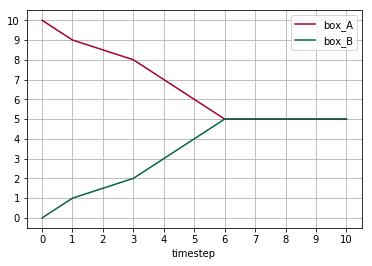

In [9]:
dfmc_median = df2.groupby(['timestep', 'substep']).median().reset_index()
dfmc_median.plot('timestep', ['box_A', 'box_B'], 
                 grid=True,
                 xticks=list(dfmc_median['timestep'].drop_duplicates()), 
                 yticks=list(range(int(1+max(dfmc_median['box_A'].max(),dfmc_median['box_B'].max())))),
                 colormap = 'RdYlGn'
                )

Or look at edge cases

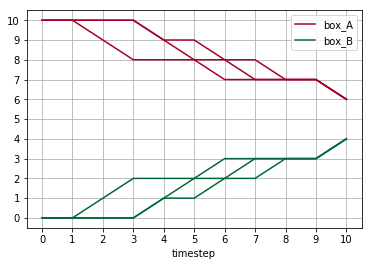

In [10]:
max_final_A = df2[df2['timestep']==df2['timestep'].max()]['box_A'].max()
# max_final_A
slow_runs = df2[(df2['timestep']==df2['timestep'].max()) & 
         (df2['box_A']==max_final_A)]['run']
slow_runs = list(slow_runs)
slow_runs

ax = None
for i in slow_runs:
    ax = df2[df2['run']==i].plot('timestep', ['box_A', 'box_B'],
                                     grid=True,
                                     xticks=list(df2['timestep'].drop_duplicates()), 
                                     yticks=list(range(1+max(df2['box_A'].max(),df2['box_B'].max()))),
                                     legend = (ax == None),
                                     colormap = 'RdYlGn',
                                     ax = ax
                                  )